<b><font color="SteelBlue" size="+3">Classifiez automatiquement des biens de consommation</font></b>

# Introduction

Ce notebook est la suite de celui sur le traitement des descriptions. On récupère les données nettoyées pour les catégories des produits.

## Imports

In [1]:
# Chargement des librairies
# Standard
import os
import time

# Data Manipulation and Analysis
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# Machine Learning
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import MiniBatchKMeans, KMeans

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Image Processing
from matplotlib.image import imread
from PIL import Image as PilImage

# Deep Learning - TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3
from keras.applications import InceptionResNetV2, DenseNet201
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg16
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet50
from tensorflow.keras.applications.inception_v3 import preprocess_input as preprocess_inception_v3
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input as preprocess_inceptionresnetv2
from tensorflow.keras.applications.densenet import preprocess_input as preprocess_densenet201

# Custom Modules
from Deveau_Estelle_4_IMG_func_042024 import *

In [2]:
print("Version de TensorFlow installée : ", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Version de TensorFlow installée :  2.16.1
Num GPUs Available:  0


## Data

In [3]:
os.listdir()

['.ipynb_checkpoints',
 'data',
 'Deveau_Estelle_1_notebook_txt_faisabilite_042024.ipynb',
 'Deveau_Estelle_2_NLP_func_042024.py',
 'Deveau_Estelle_3_notebook_img_faisabilite_042024.ipynb',
 'Deveau_Estelle_4_IMG_func_042024.py',
 'Deveau_Estelle_5_notebook_img_classification_042024.ipynb',
 'model_augmented_best.weights.h5',
 'model_augmented_data_best.weights.h5',
 'model_best.keras',
 'model_best.weights.h5',
 'model_densenet201_best.weights.h5',
 'model_inceptionresnetv2_best.weights.h5',
 'model_vgg16_best.weights.h5',
 'OC_projet6.pptx',
 'pythonProject',
 'svg',
 'Weather_Images_CNN_Transfer_Learning_Stage_1_feasibility_V1.0.ipynb',
 'Weather_Images_CNN_Transfer_Learning_Stage_2_supervised_classification_V1.0.ipynb',
 '__pycache__']

In [4]:
os.listdir("data/Cleaned/")

['data.csv']

In [5]:
path     = "./data/Cleaned/"
filename = "data.csv"

In [6]:
data = pd.read_csv(path + filename)

In [7]:
path     = "./data/Sources/Images/"
list_photos = [file for file in os.listdir(path)]
print(len(list_photos))

1050


# Exploration des données

## Quick tour

In [8]:
data.head()

uniq_id product_category  \
0  55b85ea15a1536d46b7190ad6fff8ce7  Home Furnishing   
1  7b72c92c2f6c40268628ec5f14c6d590        Baby Care   
2  64d5d4a258243731dc7bbb1eef49ad74        Baby Care   
3  d4684dcdc759dd9cdf41504698d737d8  Home Furnishing   
4  6325b6870c54cd47be6ebfbffa620ec7  Home Furnishing   

                                         description  
0  Key Features of Elegance Polyester Multicolor ...  
1  Specifications of Sathiyas Cotton Bath Towel (...  
2  Key Features of Eurospa Cotton Terry Face Towe...  
3  Key Features of SANTOSH ROYAL FASHION Cotton P...  
4  Key Features of Jaipur Print Cotton Floral Kin...

In [9]:
data.shape

(1050, 3)

In [10]:
data.dtypes.value_counts()

object    3
Name: count, dtype: int64

In [11]:
data.nunique()

uniq_id             1050
product_category       7
description         1050
dtype: int64

In [12]:
# Valeurs manquantes
missing_values_count = data.isnull().sum()
total_cells = np.product(data.shape)
total_missing = missing_values_count.sum()
percent_missing = (total_missing/total_cells) * 100
print('Le pourcentage de valeurs manquantes est de', round(percent_missing, 2),'%')

Le pourcentage de valeurs manquantes est de 0.0 %


In [13]:
# Liste de toutes les colonnes à conserver
cols_to_keep = ['uniq_id', 'product_category']

In [14]:
df = data[cols_to_keep]

In [15]:
df.head(5)

uniq_id product_category
0  55b85ea15a1536d46b7190ad6fff8ce7  Home Furnishing
1  7b72c92c2f6c40268628ec5f14c6d590        Baby Care
2  64d5d4a258243731dc7bbb1eef49ad74        Baby Care
3  d4684dcdc759dd9cdf41504698d737d8  Home Furnishing
4  6325b6870c54cd47be6ebfbffa620ec7  Home Furnishing

In [16]:
print("Valeurs uniques pour product_category dans df:", df['product_category'].unique())

Valeurs uniques pour product_category dans df: ['Home Furnishing' 'Baby Care' 'Watches' 'Home Decor & Festive Needs'
 'Kitchen & Dining' 'Beauty and Personal Care' 'Computers']


## Exemples d'images

In [21]:
import random

def get_images_for_category(category, num_images=5):
    """Récupère aléatoirement les noms de fichiers des images pour une catégorie donnée."""
    category_ids = df[df['product_category'] == category]['uniq_id']
    category_images = [f"{id}.jpg" for id in category_ids if f"{id}.jpg" in list_photos]
    # Sélection aléatoire des images si le nombre d'images est suffisant, sinon retourne toutes les images trouvées
    return random.sample(category_images, min(len(category_images), num_images)) if len(category_images) > num_images else category_images


Catégorie : Home Furnishing


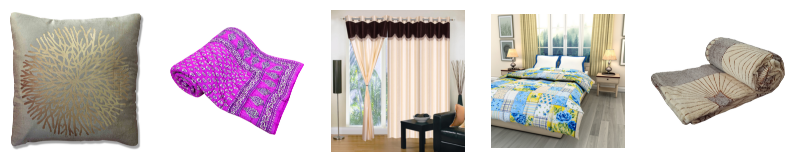

Catégorie : Baby Care


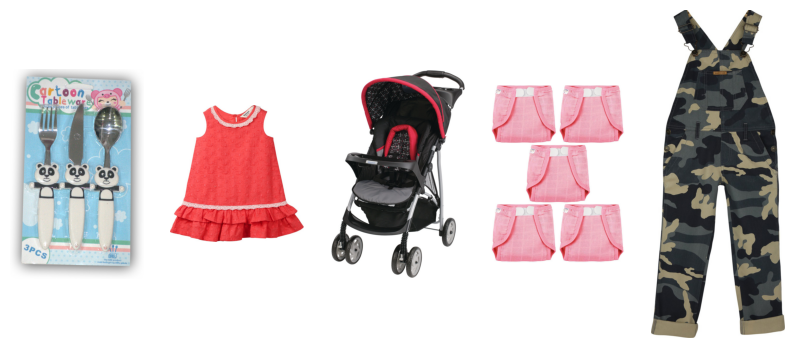

Catégorie : Watches


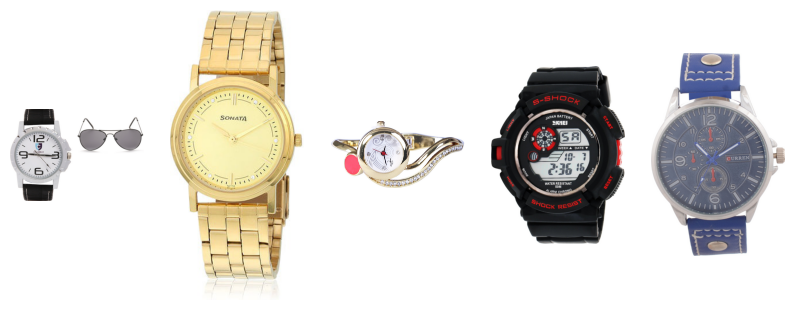

Catégorie : Home Decor & Festive Needs


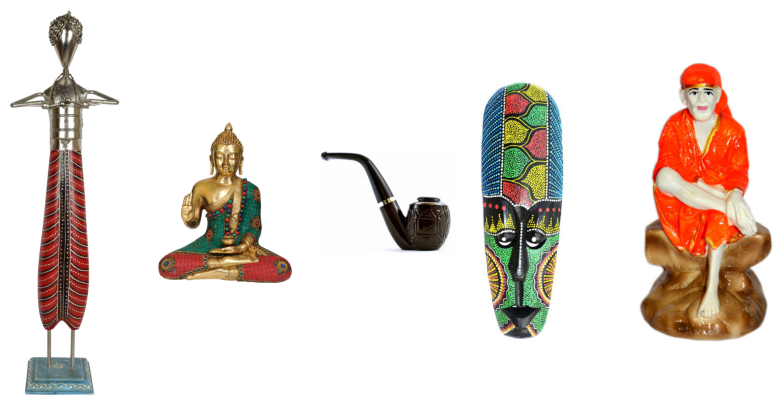

Catégorie : Kitchen & Dining


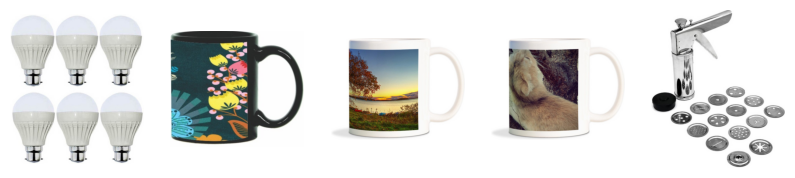

Catégorie : Beauty and Personal Care


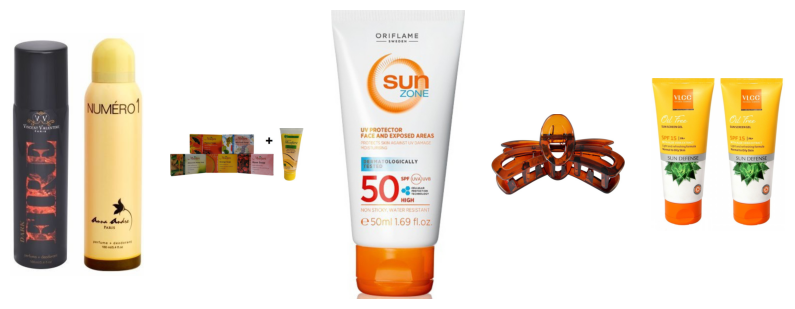

Catégorie : Computers


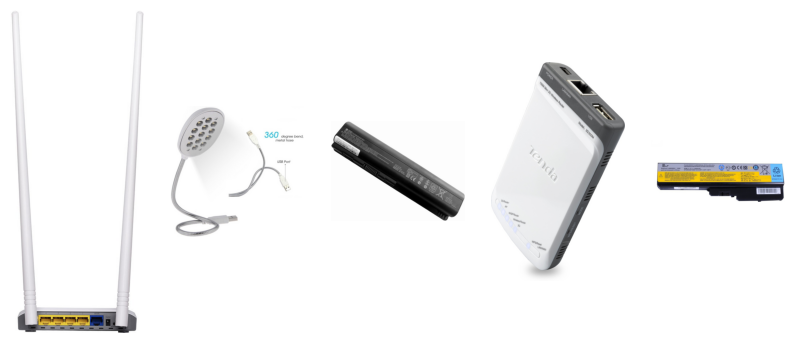

In [79]:
# Affichage des images
for category in df['product_category'].unique():
    print(f"Catégorie : {category}")
    category_images = get_images_for_category(category, 5)
    plt.figure(figsize=(10, 5)) 
    for i, image_name in enumerate(category_images):
        plt.subplot(1, 5, i+1)  
        filename = os.path.join(path, image_name)
        image = imread(filename)
        plt.imshow(image)
        plt.axis('off') 
    plt.show()

# Etude de faisabilité

## Pré-traitements des Images avec SIFT

### Détermination des descripteurs

#### Sur une image

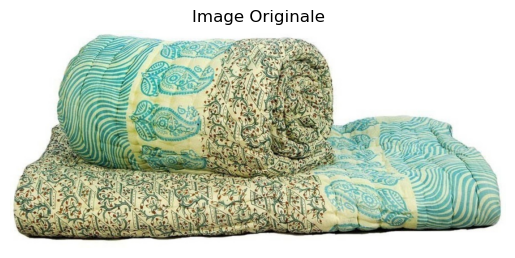

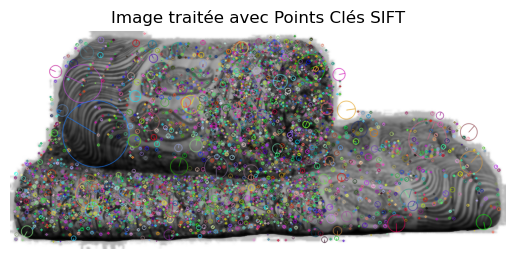

Descripteurs :  (3946, 128)
[[ 40.   2.   2. ...   0.   0.   1.]
 [134.  16.   0. ...   0.   4.   3.]
 [ 44.  91.   8. ...   0.   0.   4.]
 ...
 [  7.   5.  37. ...   0.   1.   6.]
 [ 17.   0.   0. ...   0.   0.   2.]
 [132.  81.   0. ...   0.   0.   1.]]


In [19]:
# Chemin de l'image
image_path = path + list_photos[1000]
original_image = cv2.imread(image_path)
plt_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
plt.title("Image Originale")
plt.imshow(plt_image)
plt.axis('off')
plt.show()

# Traitement de l'image avec la fonction process_image
keypoints, descriptors, processed_image = process_image(image_path)

# Affichage des points clés sur l'image
if descriptors is not None:
    display_keypoints(processed_image, keypoints, "Image traitée avec Points Clés SIFT")
    print("Descripteurs : ", descriptors.shape)
    print(descriptors)
else:
    print("Aucun descripteur trouvé.")

#### Sur chaque image

In [20]:
# Initialisation du temps
temps1 = time.time()

image_paths = [f"{path}{uid}.jpg" for uid in df['uniq_id']]

sift_keypoints_by_img, sift_keypoints_all = process_images_concurrently(image_paths)

duration1 = time.time() - temps1

print("Dimensions des descripteurs par image :", sift_keypoints_by_img.shape)
print("Nombre total de descripteurs :", sift_keypoints_all.shape)
print("Temps de traitement des descripteurs SIFT : ", "{:.2f}".format(duration1), "secondes")

Dimensions des descripteurs par image : (1050,)
Nombre total de descripteurs : (2961542, 128)
Temps de traitement des descripteurs SIFT :  110.78 secondes


### Création des clusters de descripteurs

In [21]:
temps1=time.time()

k = int(round(np.sqrt(len(sift_keypoints_all)),0))
print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs ...")

# Clustering
kmeans = MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=42, n_init=10)
kmeans.fit(sift_keypoints_all)

duration1=time.time()-temps1
print("Temps de traitement kmeans : ", "{:.2f}".format(duration1), "secondes")

Nombre de clusters estimés :  1721
Création de 1721 clusters de descripteurs ...
Temps de traitement kmeans :  89.77 secondes


### Création des features des images

In [22]:
# Creation of histograms (features)
temps1=time.time()

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Creation of a matrix of histograms
hist_vectors=[]

for i, image_desc in enumerate(sift_keypoints_by_img) :
    if i%100 == 0 : print(i)  
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

im_features = np.asarray(hist_vectors)

duration1=time.time()-temps1
print("Temps de traitement kmeans : ", "{:.2f}".format(duration1), "secondes")

0
100
200
300
400
500
600
700
800
900
1000
Temps de traitement kmeans :  50.20 secondes


### Réduction de dimension

#### ACP

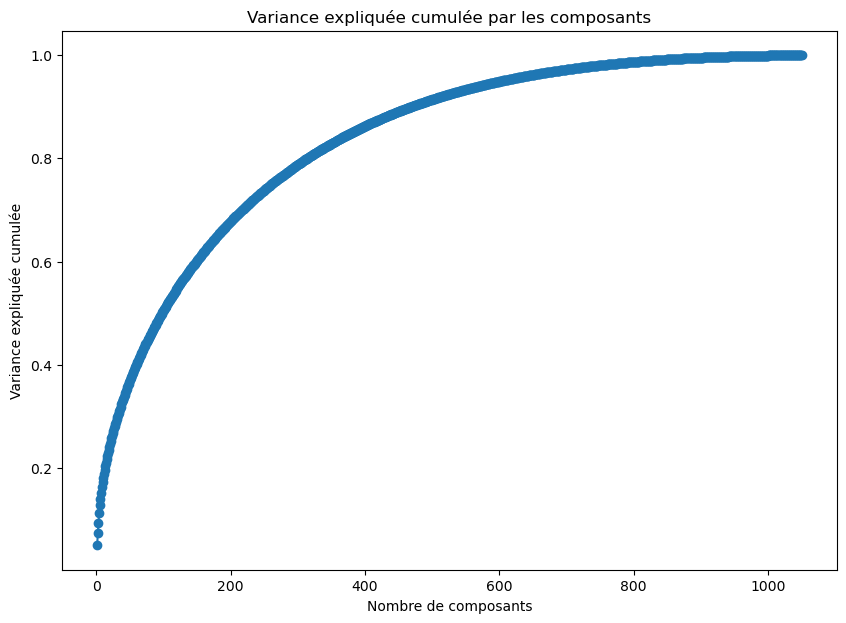

In [23]:
# Création de l'ACP
pca = PCA()

scaler = StandardScaler()
features_scaled = scaler.fit_transform(im_features)

# Application de l'ACP sur les données prétraitées
X_pca = pca.fit_transform(features_scaled)

plt.figure(figsize=(10, 7))
plt.plot(range(1, pca.n_components_ + 1),
         pca.explained_variance_ratio_.cumsum(),
         marker='o',
         linestyle='--')
plt.title('Variance expliquée cumulée par les composants')
plt.xlabel('Nombre de composants')
plt.ylabel('Variance expliquée cumulée')
plt.show()

In [24]:
# Calcul de la variance expliquée cumulée
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Trouver le nombre de composantes pour atteindre le seuil de variance expliquée
n_components_99 = np.where(cumulative_variance >= 0.99)[0][0] + 1

print(f"Nombre de composantes pour atteindre 99% de variance expliquée : {n_components_99}")

Nombre de composantes pour atteindre 99% de variance expliquée : 830


In [25]:
# PCA
pca = PCA(n_components=n_components_99, svd_solver='randomized', random_state=42)
reduced_im_features = pca.fit_transform(features_scaled)

#### T-SNE

In [26]:
# Encodage des catégories
label_encoder = LabelEncoder()
categories_encoded = label_encoder.fit_transform(df['product_category'])
category_names = label_encoder.classes_

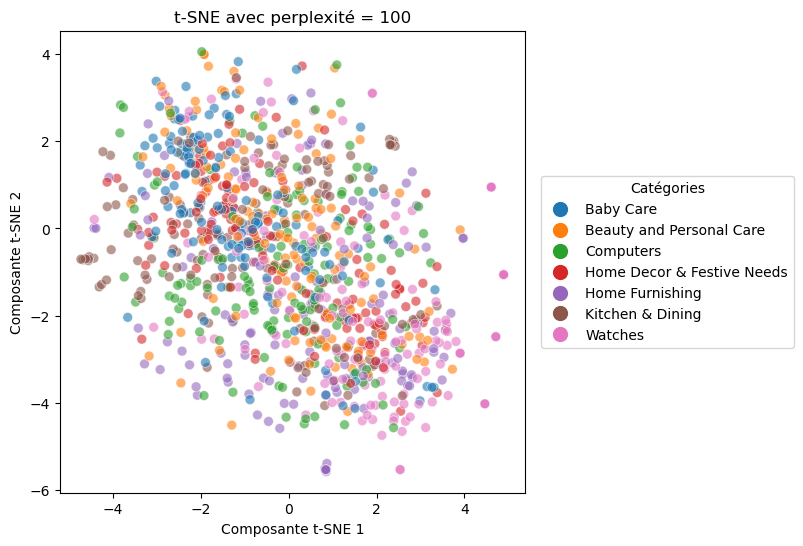

array([[-0.81017566, -0.38657472],
       [-2.0858068 ,  1.8245369 ],
       [ 0.7523549 , -0.12030721],
       ...,
       [ 0.9344547 , -2.0622115 ],
       [ 0.45146075,  0.25783548],
       [-1.7169224 , -1.609235  ]], dtype=float32)

In [27]:
plot_tsne(reduced_im_features, categories_encoded, category_names, 100)

In [28]:
tsne = TSNE(n_components=2, verbose=0, perplexity=100, random_state=42)
tsne_reduced_im_features = tsne.fit_transform(reduced_im_features)

## Pré-traitement des images avec CNN

### Modèle basique

In [29]:
def build_basic_model(input_shape=(64, 64, 3)):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(7, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

### Modèle Intermédiaire

In [30]:
def build_intermediate_model(input_shape=(64, 64, 3)):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(7, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

### Comparaison avec des Modèles avancés

In [31]:
models = {
    'Basic_Model': (lambda: build_basic_model((64, 64, 3)), (64, 64, 3), lambda x: x/255.0),
    'Intermediate_Model': (lambda: build_intermediate_model((64, 64, 3)), (64, 64, 3), lambda x: x/255.0),
    'VGG16': (lambda: VGG16(weights='imagenet', include_top=False), (224, 224, 3), preprocess_vgg16),
    'ResNet50': (lambda: ResNet50(weights='imagenet', include_top=False), (224, 224, 3), preprocess_resnet50),
    'InceptionV3': (lambda: InceptionV3(weights='imagenet', include_top=False), (299, 299, 3), preprocess_inception_v3),
    'InceptionResNetV2': (lambda: InceptionResNetV2(weights='imagenet', include_top=False), (299, 299, 3), preprocess_inceptionresnetv2),
    'DenseNet201': (lambda: DenseNet201(weights='imagenet', include_top=False), (224, 224, 3), preprocess_densenet201)
}

In [32]:
def create_feature_extractor(base_model_func, input_shape):
    # Instancier le modèle
    model = base_model_func()

    # Geler toutes les couches du modèle de base pour empêcher leur entraînement
    for layer in model.layers:
        layer.trainable = False

    # Déterminer si la couche de pooling peut être ajoutée
    if len(model.output_shape) == 4:  # La sortie est 4D, donc pooling est possible
        x = GlobalAveragePooling2D()(model.output)
        feature_extractor = Model(inputs=model.input, outputs=x)
    else:
        # Si la sortie n'est pas 4D, utiliser la sortie telle quelle
        feature_extractor = Model(inputs=model.input, outputs=model.output)

    return feature_extractor

In [33]:
# Fonction pour extraire les caractéristiques des images par lots
def extract_features(image_paths, model, target_size, preprocess_function, batch_size=50):
    features_list = []
    # Traiter les images par lots
    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i + batch_size]
        batch_images = [image_prep_fct([path], preprocess_function, target_size[:2]) for path in batch_paths]
        batch_images = np.vstack(batch_images)
        batch_features = model.predict(batch_images, verbose=0)
        features_list.append(batch_features.reshape(batch_features.shape[0], -1))

    # Concaténer toutes les features extraites dans un seul tableau numpy
    return np.vstack(features_list)

In [34]:
# Définir le seuil à un niveau supérieur spécifique
PilImage.MAX_IMAGE_PIXELS = 100000000

In [35]:
dfs = {}
for model_name, (base_model_func, size, preprocess) in models.items():
    print(f"Traitement avec {model_name}")
    
    # Début du chronométrage
    start_time = time.time()
    
    # Créer l'extracteur de caractéristiques
    feature_extractor = create_feature_extractor(base_model_func, size)
    features = extract_features(image_paths, feature_extractor, size, preprocess)
    df_features = pd.DataFrame(features)
    
    # Fin du chronométrage
    end_time = time.time()
    
    # Calcul de la durée
    duration = end_time - start_time
    dfs[model_name] = df_features
    
    print(f"DataFrame pour {model_name} créé avec succès en {duration:.2f} secondes.")

Traitement avec Basic_Model
DataFrame pour Basic_Model créé avec succès en 16.07 secondes.
Traitement avec Intermediate_Model
DataFrame pour Intermediate_Model créé avec succès en 15.30 secondes.
Traitement avec VGG16
DataFrame pour VGG16 créé avec succès en 66.04 secondes.
Traitement avec ResNet50
DataFrame pour ResNet50 créé avec succès en 45.30 secondes.
Traitement avec InceptionV3
DataFrame pour InceptionV3 créé avec succès en 48.08 secondes.
Traitement avec InceptionResNetV2

DataFrame pour InceptionResNetV2 créé avec succès en 105.64 secondes.
Traitement avec DenseNet201
DataFrame pour DenseNet201 créé avec succès en 68.91 secondes.


### Réduction de dimension

#### ACP

In [36]:
# Dictionnaire pour stocker les résultats de l'ACP pour chaque modèle
pca_results = {}

for model_name, df_features in dfs.items():
    print(f"Traitement du modèle {model_name}")

    # Standardisation des caractéristiques
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(df_features)
    
    # Application de l'ACP pour conserver 99% de la variance
    pca = PCA(n_components=0.99)  # Réglage pour conserver 99% de la variance
    features_pca = pca.fit_transform(features_scaled)
    
    # Création d'un DataFrame pour les résultats de l'ACP
    df_pca = pd.DataFrame(features_pca, columns=[f'PC{i+1}' for i in range(features_pca.shape[1])])
    
    # Stockage des résultats dans le dictionnaire
    pca_results[model_name] = df_pca
    
    # Affichage du nombre de composantes utilisées pour atteindre 99% de variance
    print(f"ACP terminée pour {model_name}. Nombre de composantes: {pca.n_components_}")

Traitement du modèle Basic_Model
ACP terminée pour Basic_Model. Nombre de composantes: 4
Traitement du modèle Intermediate_Model
ACP terminée pour Intermediate_Model. Nombre de composantes: 5
Traitement du modèle VGG16
ACP terminée pour VGG16. Nombre de composantes: 413
Traitement du modèle ResNet50
ACP terminée pour ResNet50. Nombre de composantes: 786
Traitement du modèle InceptionV3
ACP terminée pour InceptionV3. Nombre de composantes: 712
Traitement du modèle InceptionResNetV2
ACP terminée pour InceptionResNetV2. Nombre de composantes: 522
Traitement du modèle DenseNet201
ACP terminée pour DenseNet201. Nombre de composantes: 750


#### T-SNE

In [84]:
# Définition des perplexités pour chaque modèle
model_perplexities = {
    'Basic_Model': 40,
    'Intermediate_Model': 40,
    'VGG16': 50,
    'ResNet50': 120,
    'InceptionV3': 20,
    'InceptionResNetV2' : 55,
    'DenseNet201' : 120
}

Applying t-SNE to Basic_Model


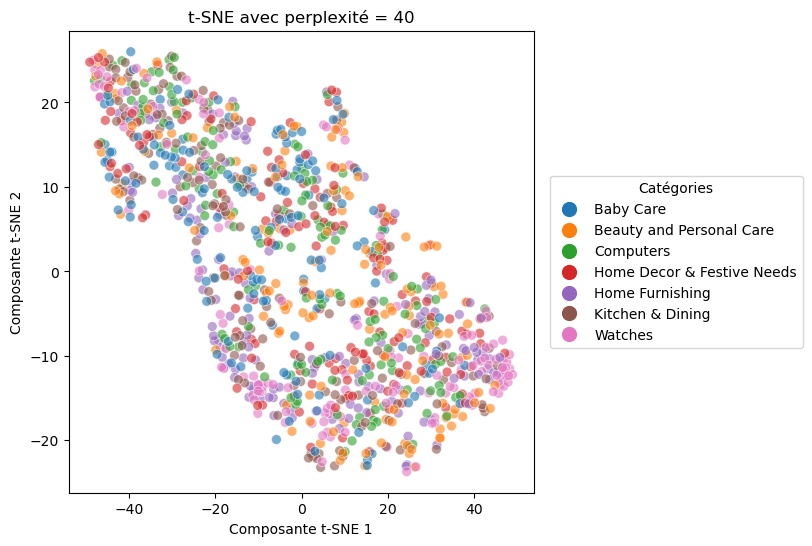

Applying t-SNE to Intermediate_Model


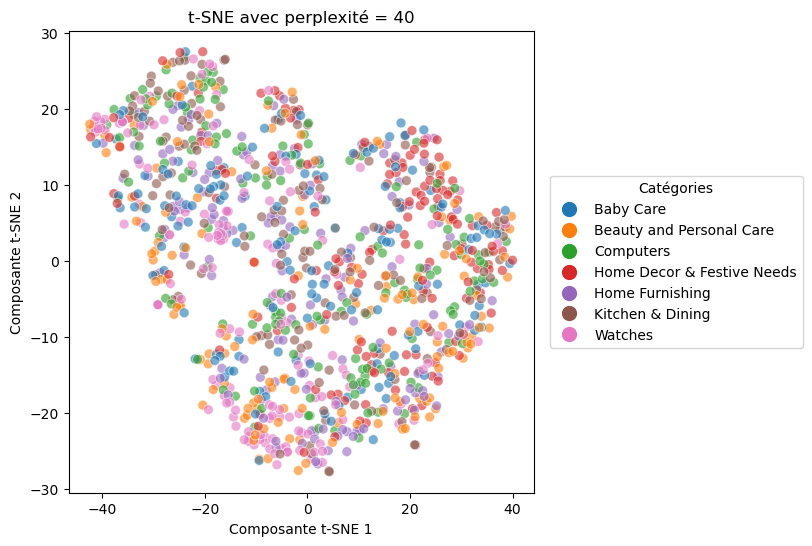

Applying t-SNE to VGG16


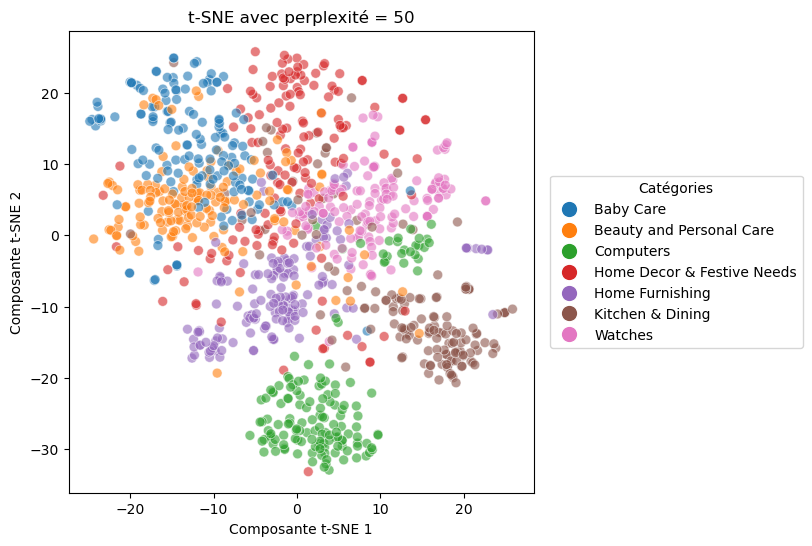

Applying t-SNE to ResNet50


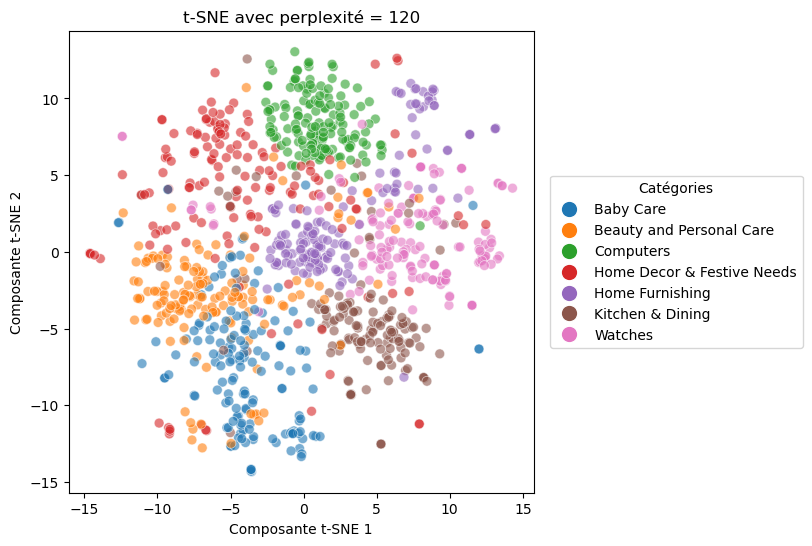

Applying t-SNE to InceptionV3


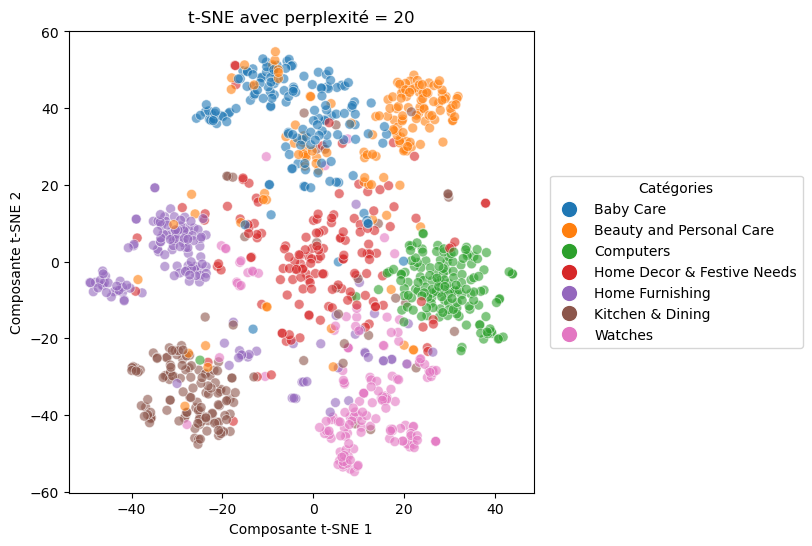

Applying t-SNE to InceptionResNetV2


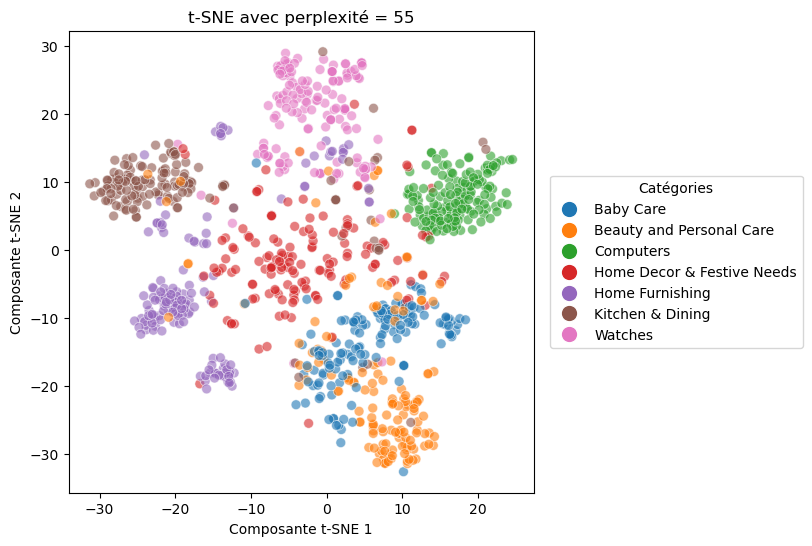

Applying t-SNE to DenseNet201


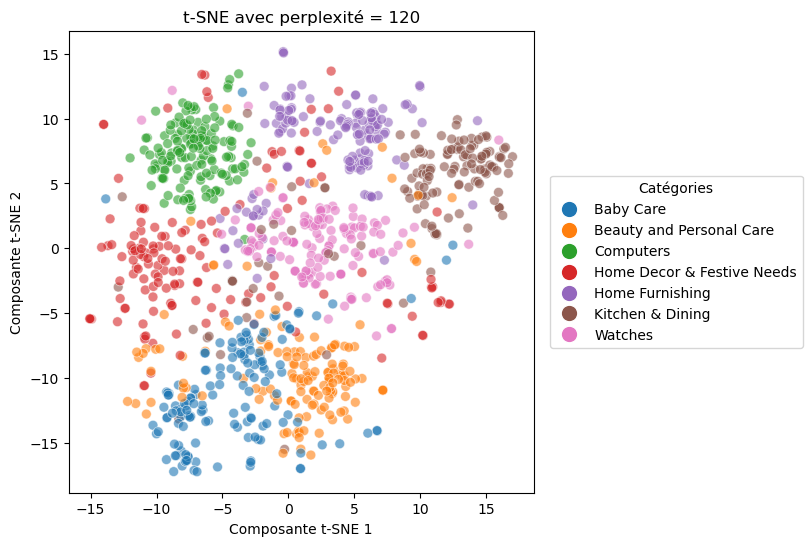

In [85]:
tsne_results = {}  # Dictionnaire pour stocker les résultats de t-SNE pour chaque modèle

for model_name, df_pca in pca_results.items():
    pca_features = df_pca.copy()
    print(f"Applying t-SNE to {model_name}")
    tsne_results[model_name] = plot_tsne(pca_features, categories_encoded, category_names,perplexity=model_perplexities[model_name])

## K-means

In [39]:
# Nombre de clusters
n_clusters = 7

### Sur SIFT

Silhouette Score: 0.3374
Adjusted Rand Score: 0.0520
Accuracy: 0.2724


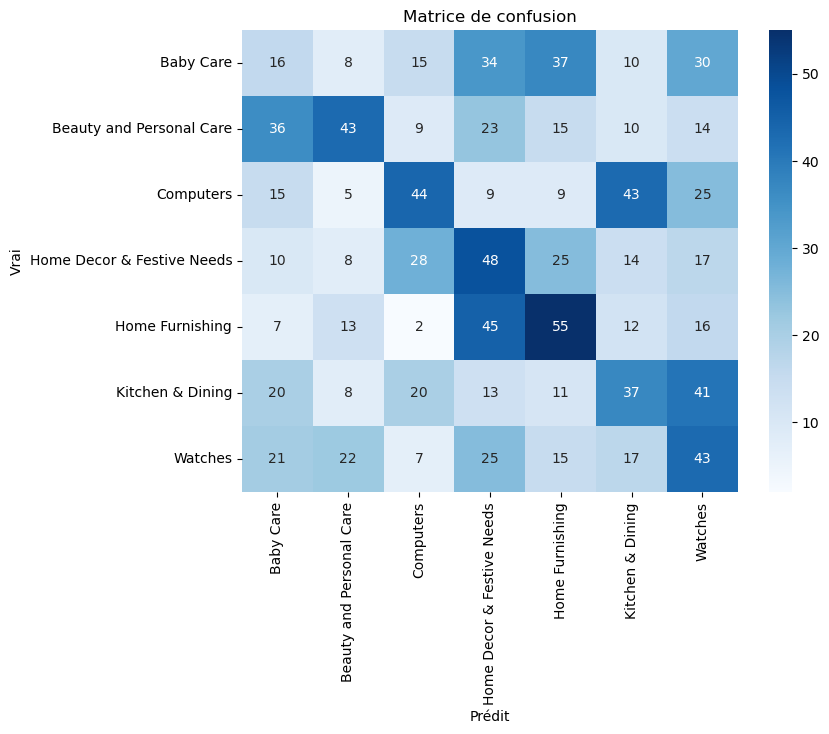

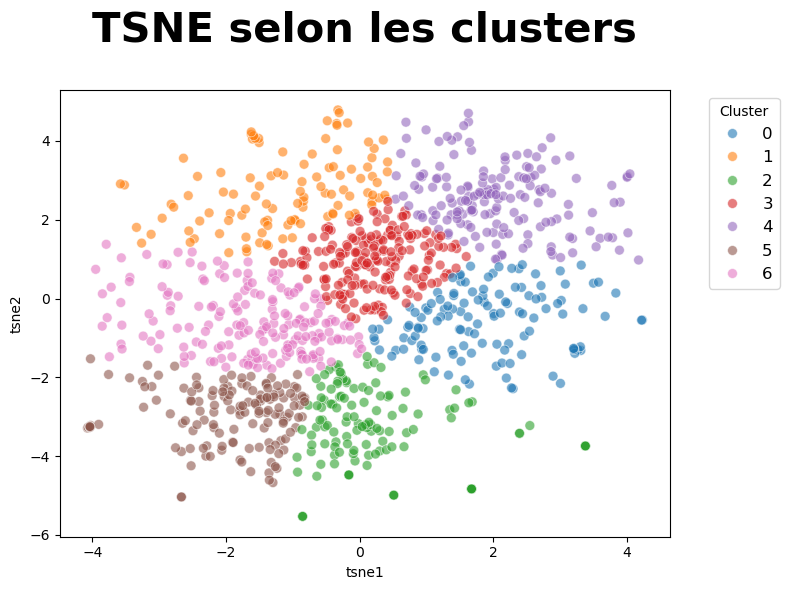

In [40]:
kmeans_metrics_sift = perform_kmeans(X_data=tsne_reduced_im_features, true_labels=categories_encoded, label_names=category_names,
                                n_clusters=n_clusters, random_state=42)

### Sur CNN

Applying K-means to t-SNE results of Basic_Model
Silhouette Score: 0.4263
Adjusted Rand Score: 0.0247
Accuracy: 0.2305


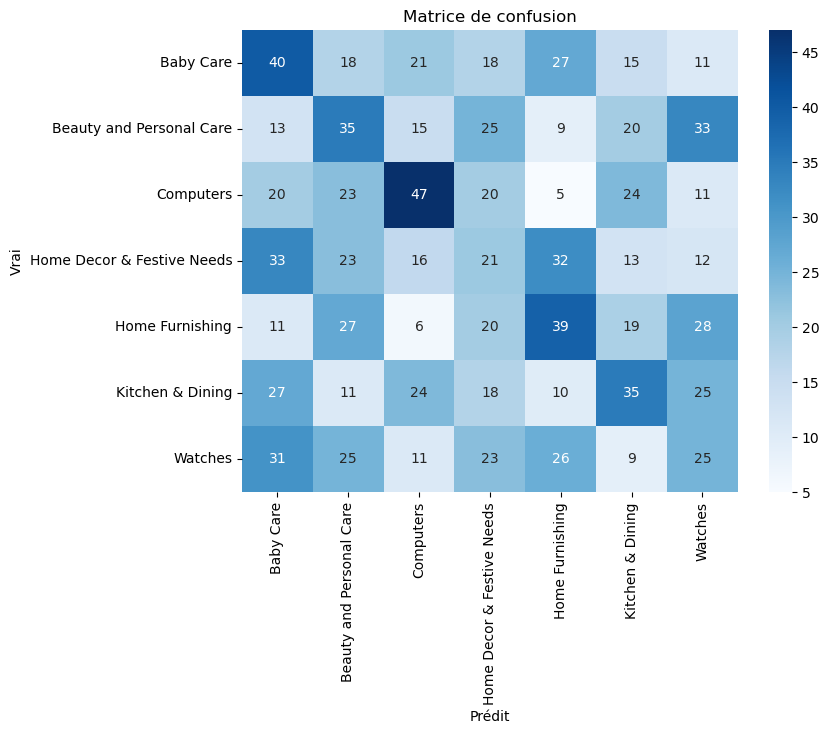

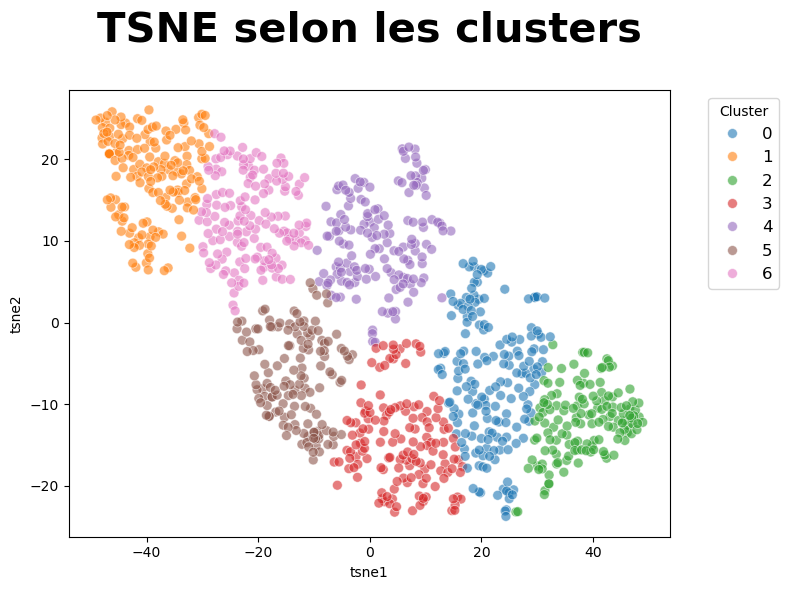

Applying K-means to t-SNE results of Intermediate_Model
Silhouette Score: 0.3937
Adjusted Rand Score: 0.0290
Accuracy: 0.2381


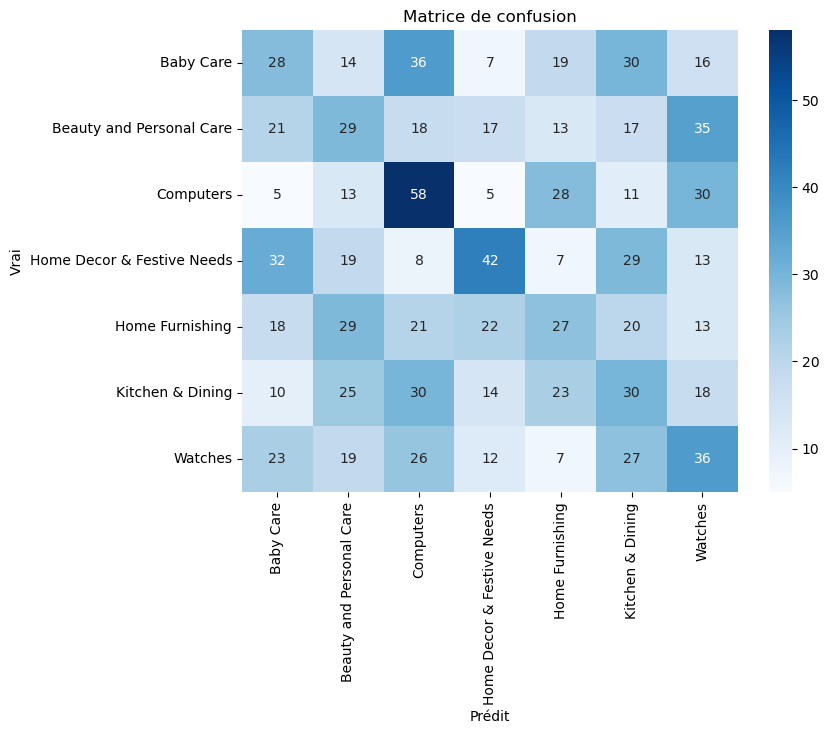

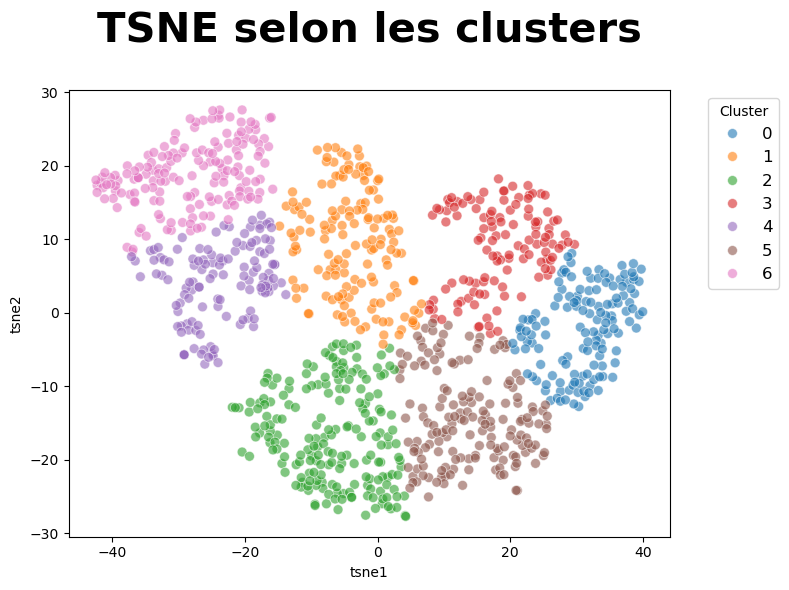

Applying K-means to t-SNE results of VGG16
Silhouette Score: 0.4202
Adjusted Rand Score: 0.5033
Accuracy: 0.7410


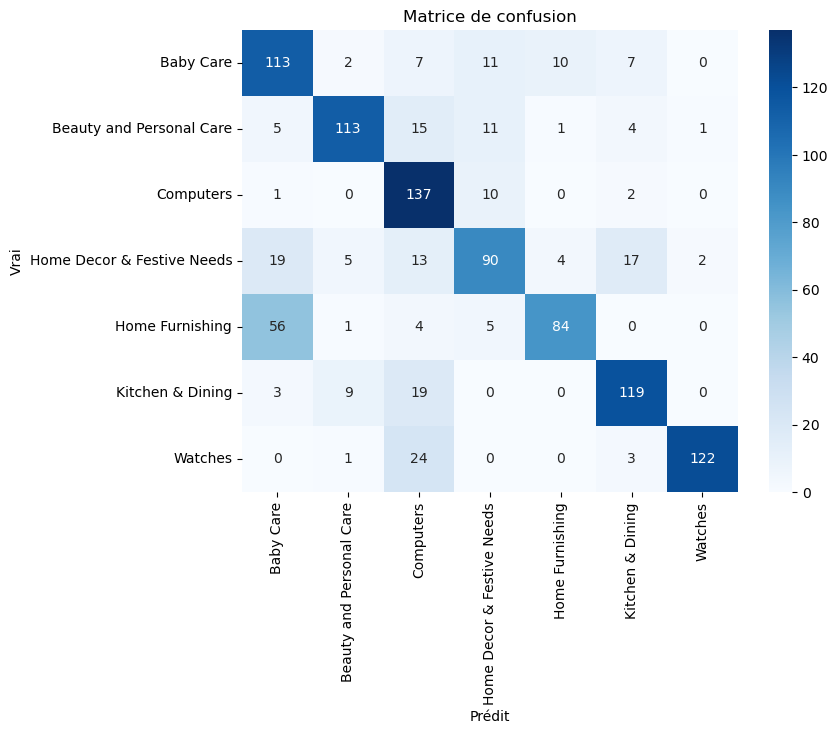

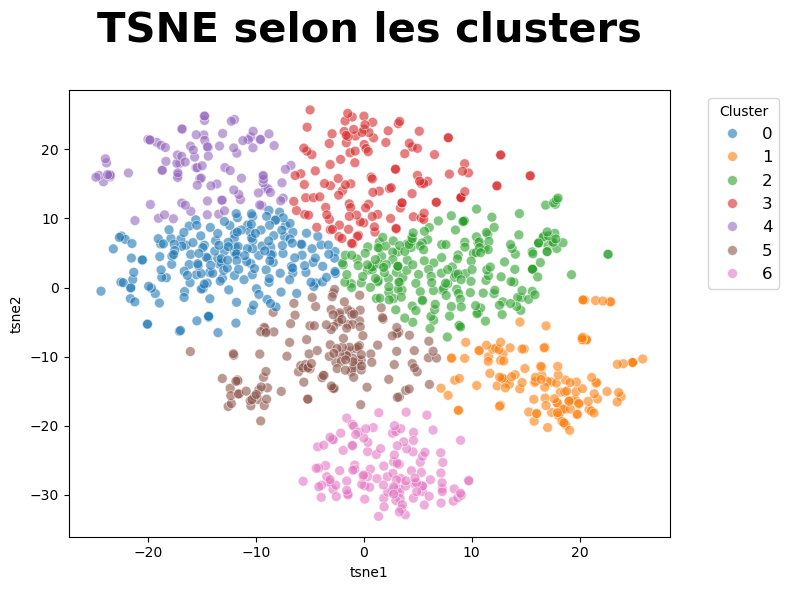

Applying K-means to t-SNE results of ResNet50
Silhouette Score: 0.4079
Adjusted Rand Score: 0.5065
Accuracy: 0.7362


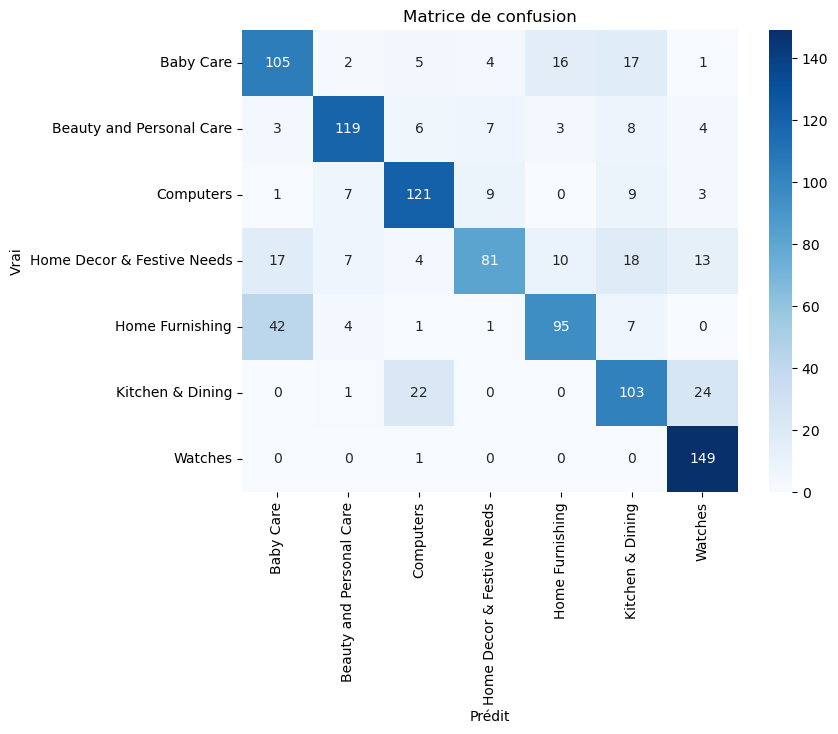

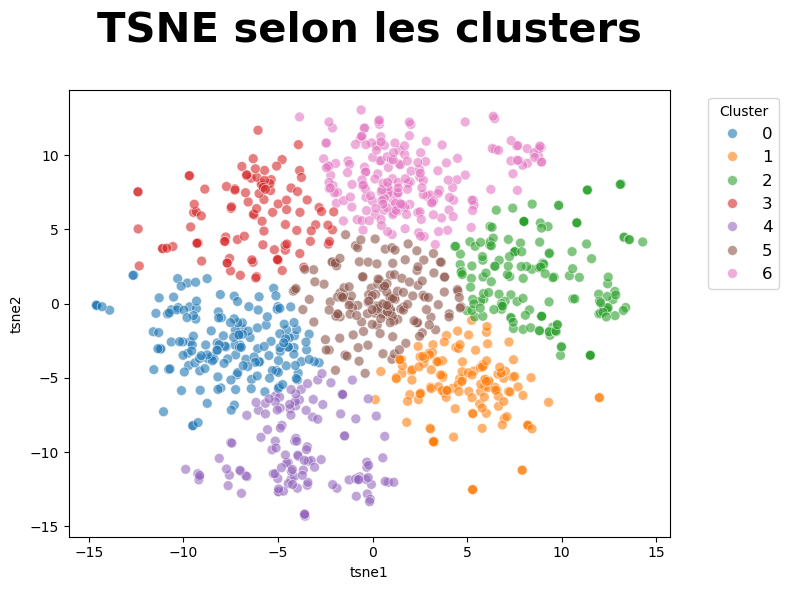

Applying K-means to t-SNE results of InceptionV3
Silhouette Score: 0.4866
Adjusted Rand Score: 0.5612
Accuracy: 0.7743


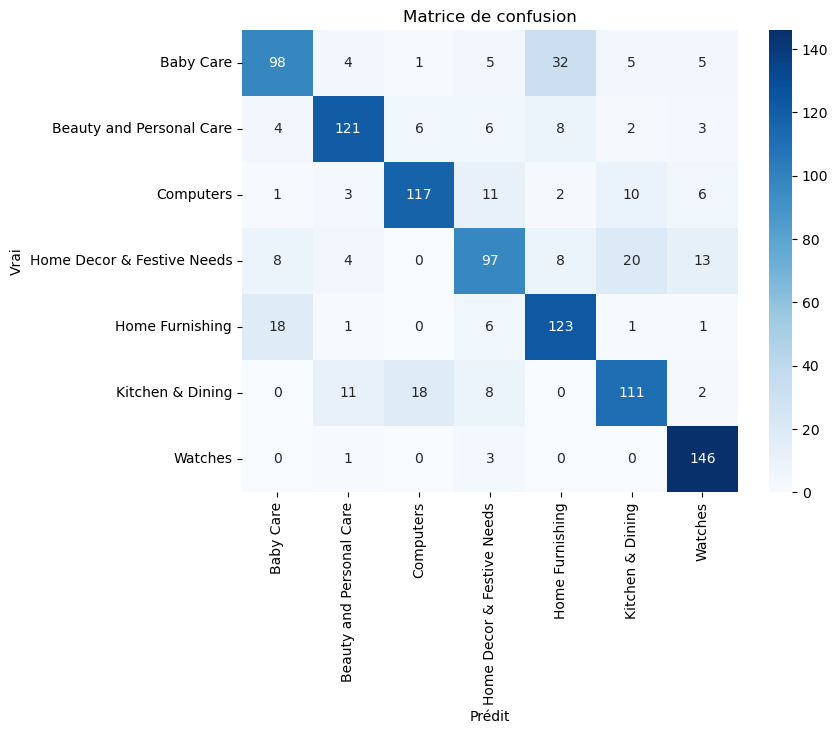

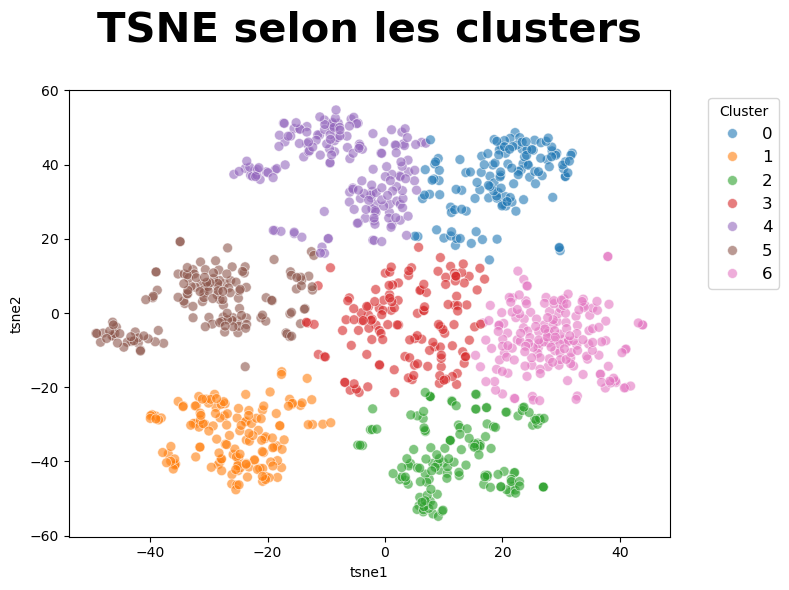

Applying K-means to t-SNE results of InceptionResNetV2
Silhouette Score: 0.5039
Adjusted Rand Score: 0.6032
Accuracy: 0.7848


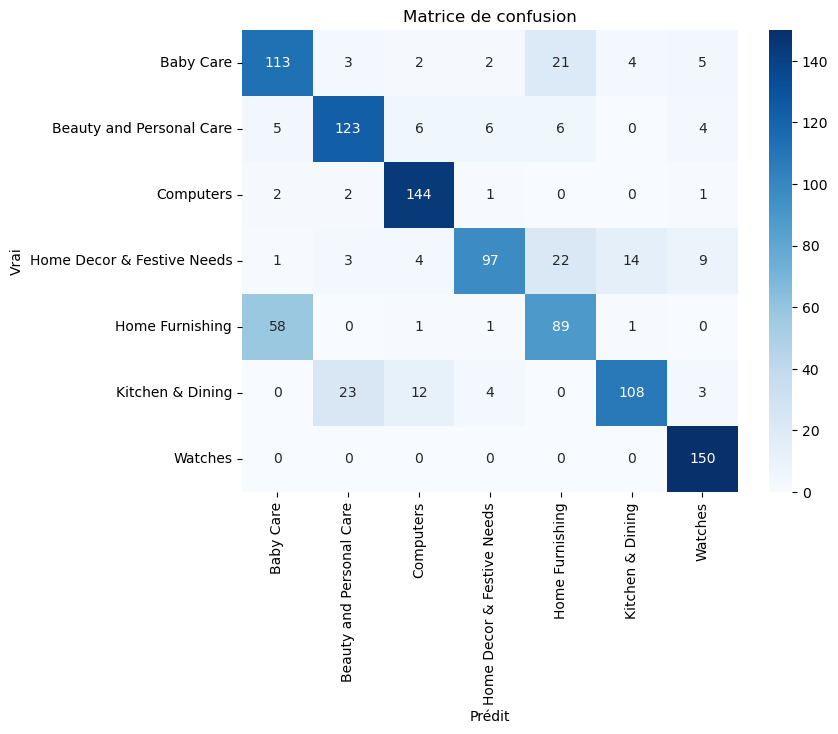

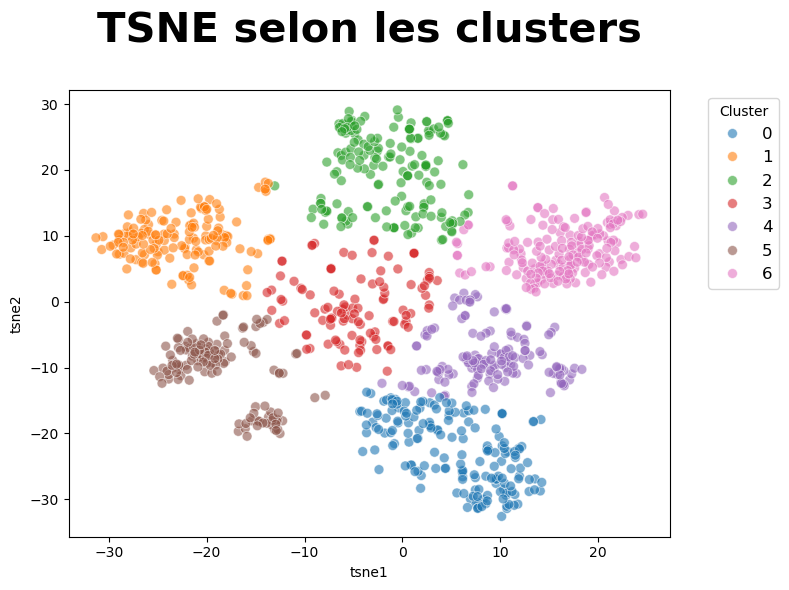

Applying K-means to t-SNE results of DenseNet201
Silhouette Score: 0.4337
Adjusted Rand Score: 0.5802
Accuracy: 0.7790


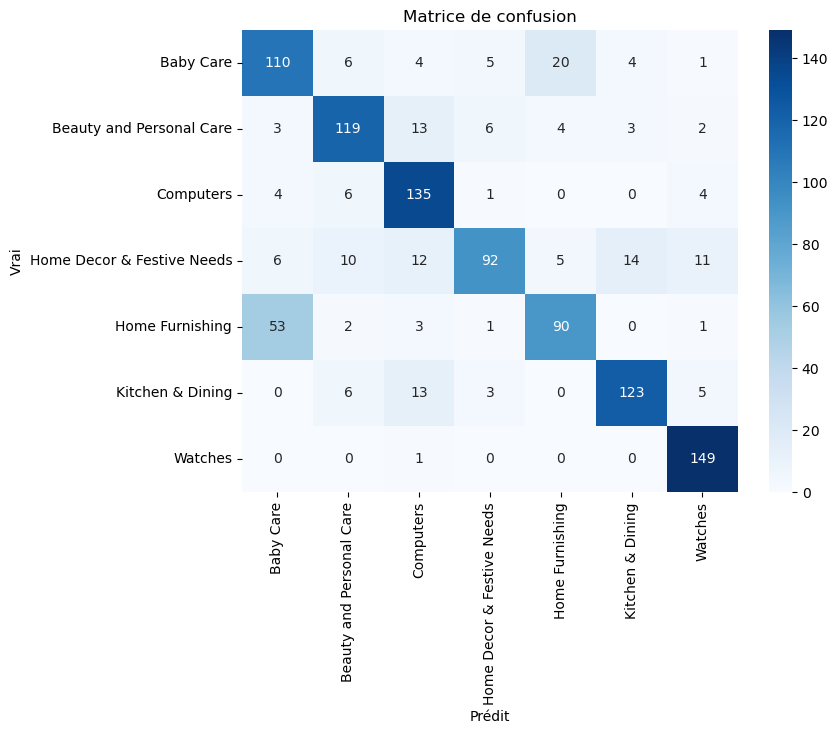

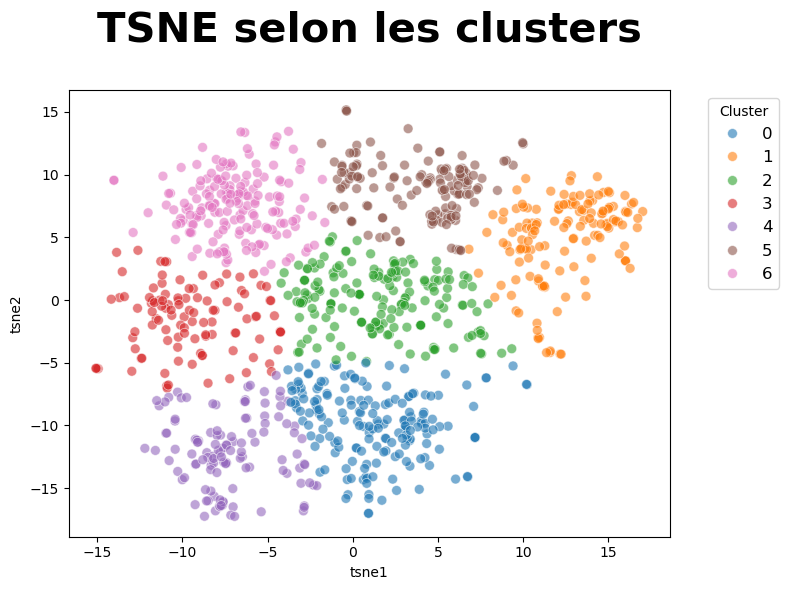

In [86]:
# Dictionnaire pour stocker les métriques de chaque modèle
kmeans_metrics = {}

for model_name, tsne_data in tsne_results.items():
    print(f"Applying K-means to t-SNE results of {model_name}")
    metrics = perform_kmeans(
        X_data=tsne_data, 
        true_labels=categories_encoded,
        label_names=category_names,
        n_clusters=n_clusters,
        random_state=42
    )
    
    # Stocker les métriques pour chaque modèle
    kmeans_metrics[model_name] = metrics

### Comparaison des résultats

In [87]:
# concaténation des resultats
all_metrics = {
    'SIFT': kmeans_metrics_sift,
    **kmeans_metrics
}

# Consolidation des données
data = []
for method, metrics_dict in all_metrics.items():
    for metric_name, value in metrics_dict.items():
        data.append({
            'Method': method,
            'Metric': metric_name,
            'Score': value
        })

data_metrics = pd.DataFrame(data)

In [88]:
data_metrics.head(5)

Method               Metric     Score
0         SIFT     Silhouette Score  0.337418
1         SIFT  Adjusted Rand Score  0.052005
2         SIFT             Accuracy  0.272381
3  Basic_Model     Silhouette Score  0.426339
4  Basic_Model  Adjusted Rand Score  0.024694

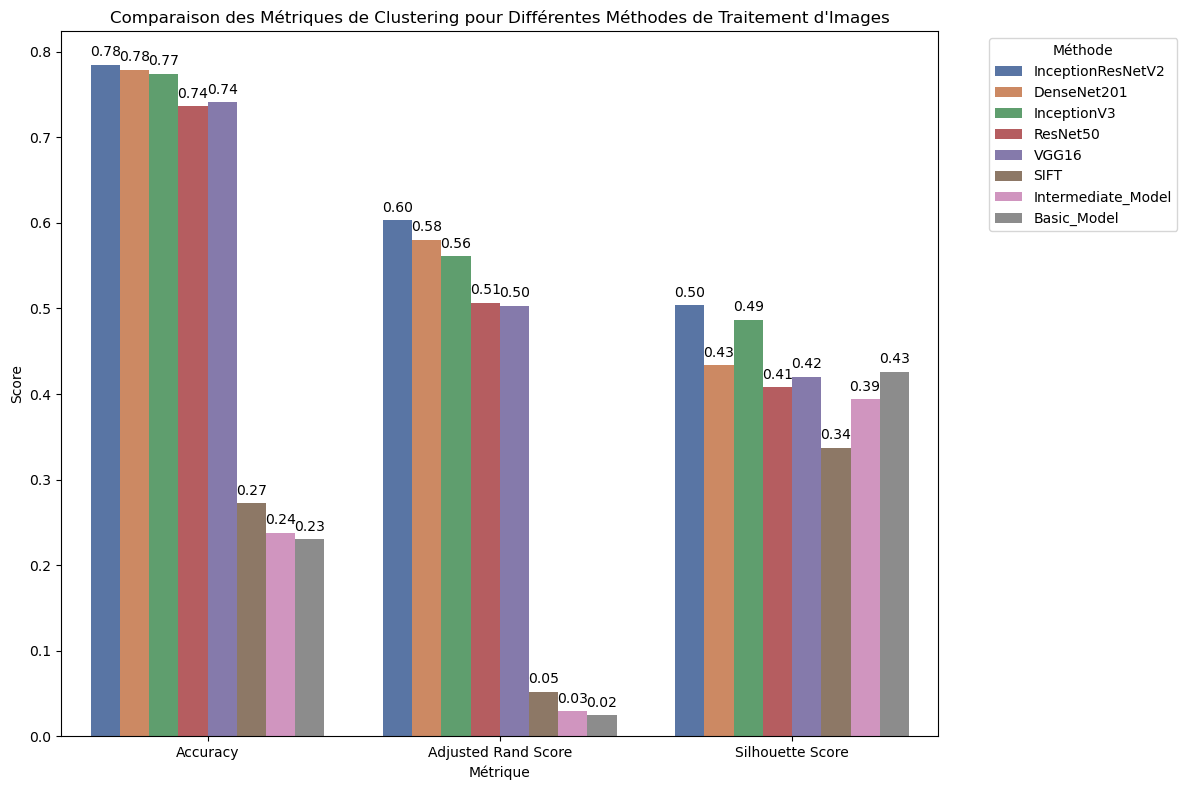

In [89]:
# Trier les données pour la visualisation
sorted_methods = data_metrics[data_metrics['Metric'] == 'Adjusted Rand Score'].sort_values(by='Score', ascending=False)['Method'].unique()

# Assurer l'ordre des méthodes dans le DataFrame pour le graphique
data_metrics['Method'] = pd.Categorical(data_metrics['Method'], categories=sorted_methods, ordered=True)
data_metrics = data_metrics.sort_values('Method')

# Création du graphique
plt.figure(figsize=(12, 8))
barplot = sns.barplot(data=data_metrics, x='Metric', y='Score', hue='Method', palette='deep')

# Ajouter des valeurs de score sur les barres pour une meilleure lisibilité
for p in barplot.patches:
    if p.get_height() > 0:
        barplot.annotate(format(p.get_height(), '.2f'), 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha = 'center', va = 'center', 
                         xytext = (0, 9), 
                         textcoords = 'offset points')

# Configuration finale
plt.title('Comparaison des Métriques de Clustering pour Différentes Méthodes de Traitement d\'Images')
plt.xlabel('Métrique')
plt.ylabel('Score')
plt.legend(title='Méthode', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()